100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:13<00:00, 1936695.55it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 103834.30it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:02<00:00, 1477427.89it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


==> CrossEntropy Loss 실험 시작
[1] Loss: 0.8136, Accuracy: 70.54%
[2] Loss: 0.6370, Accuracy: 76.28%
[3] Loss: 0.5994, Accuracy: 76.56%
[4] Loss: 0.5145, Accuracy: 80.87%
[5] Loss: 0.4836, Accuracy: 81.62%
[6] Loss: 0.4794, Accuracy: 81.92%
[7] Loss: 0.4528, Accuracy: 82.78%
[8] Loss: 0.4342, Accuracy: 83.27%
[9] Loss: 0.4518, Accuracy: 83.14%
[10] Loss: 0.4183, Accuracy: 83.89%
[11] Loss: 0.4718, Accuracy: 81.81%
[12] Loss: 0.4066, Accuracy: 83.89%
[13] Loss: 0.3887, Accuracy: 84.94%
[14] Loss: 0.3942, Accuracy: 84.53%
[15] Loss: 0.4028, Accuracy: 83.99%
[16] Loss: 0.3832, Accuracy: 84.65%
[17] Loss: 0.3705, Accuracy: 85.19%
[18] Loss: 0.3748, Accuracy: 84.88%
[19] Loss: 0.3601, Accuracy: 85.42%
[20] Loss: 0.3591, Accuracy: 85.43%
[21] Loss: 0.4083, Accuracy: 84.36%
[22] Loss: 0.3673, Accuracy: 84.78%
[23] Loss: 0.3407, Accuracy: 85.99%
[24] Loss: 0.3411, Accuracy: 86.16%
[25] Loss: 0.3361, Accuracy

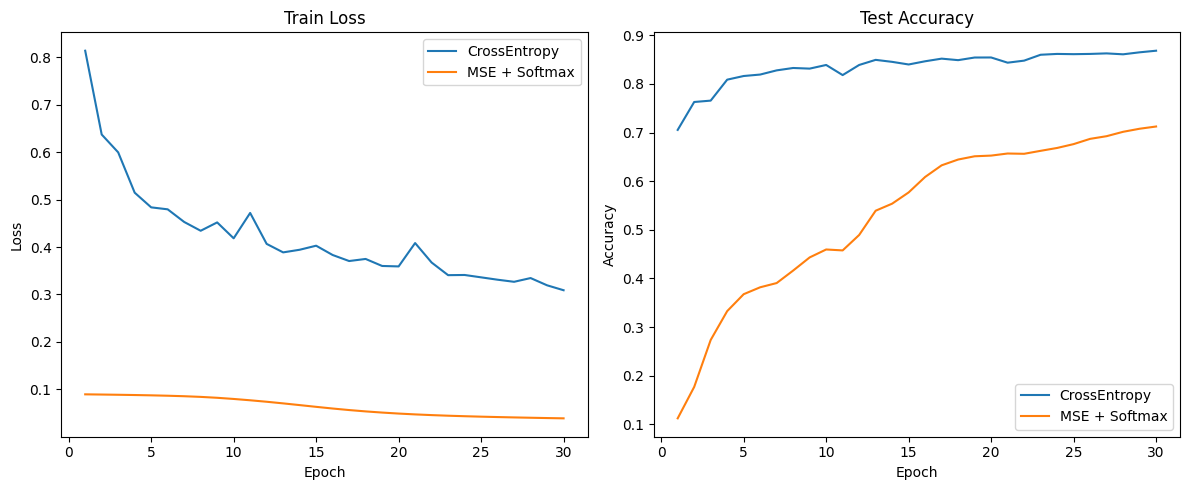

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 1. 하이퍼파라미터 설정
input_size = 28 * 28
num_classes = 10
batch_size = 64
epochs = 30
lr = 0.01

# 2. 데이터셋 로드 (Fashion-MNIST)
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1))  # Flatten
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # 마지막에 softmax는 필요시 별도 적용

# 4. 평가 함수
def evaluate(model, dataloader, loss_fn, use_softmax=False):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for x, y in dataloader:
            outputs = model(x)
            if use_softmax:
                outputs = F.softmax(outputs, dim=1)
                y_onehot = F.one_hot(y, num_classes=num_classes).float()
                loss = loss_fn(outputs, y_onehot)
            else:
                loss = loss_fn(outputs, y)
            total_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)
    return total_loss / total, correct / total

# 5. 학습 함수
def train(model, optimizer, loss_fn, use_softmax=False):
    train_losses, test_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            outputs = model(x)
            if use_softmax:
                outputs = F.softmax(outputs, dim=1)
                y_onehot = F.one_hot(y, num_classes=num_classes).float()
                loss = loss_fn(outputs, y_onehot)
            else:
                loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()
        # 평가
        train_loss, train_acc = evaluate(model, train_loader, loss_fn, use_softmax)
        test_loss, test_acc = evaluate(model, test_loader, loss_fn, use_softmax)
        train_losses.append(train_loss)
        test_accuracies.append(test_acc)
        print(f"[{epoch+1}] Loss: {train_loss:.4f}, Accuracy: {test_acc*100:.2f}%")
    return train_losses, test_accuracies

# 6. 실험 A.1 CrossEntropy Loss 실험
model_ce = MLP(input_size, num_classes)
optimizer_ce = optim.SGD(model_ce.parameters(), lr=lr)
loss_fn_ce = nn.CrossEntropyLoss()

print("\n==> CrossEntropy Loss 실험 시작")
train_losses_ce, test_accuracies_ce = train(model_ce, optimizer_ce, loss_fn_ce, use_softmax=False)

# 7. 실험 A.2 MSE Loss with softmax 실험
model_mse = MLP(input_size, num_classes)
optimizer_mse = optim.SGD(model_mse.parameters(), lr=lr)
loss_fn_mse = nn.MSELoss()

print("\n==> MSE Loss (with Softmax) 실험 시작")
train_losses_mse, test_accuracies_mse = train(model_mse, optimizer_mse, loss_fn_mse, use_softmax=True)

# 8. 결과 시각화
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses_ce, label='CrossEntropy')
plt.plot(epochs_range, train_losses_mse, label='MSE + Softmax')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_accuracies_ce, label='CrossEntropy')
plt.plot(epochs_range, test_accuracies_mse, label='MSE + Softmax')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


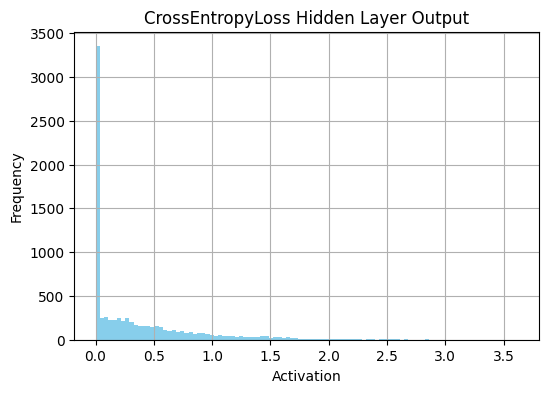

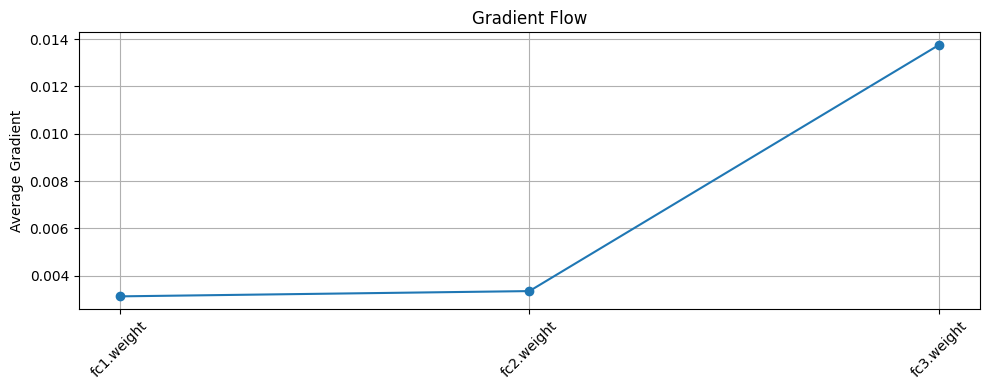

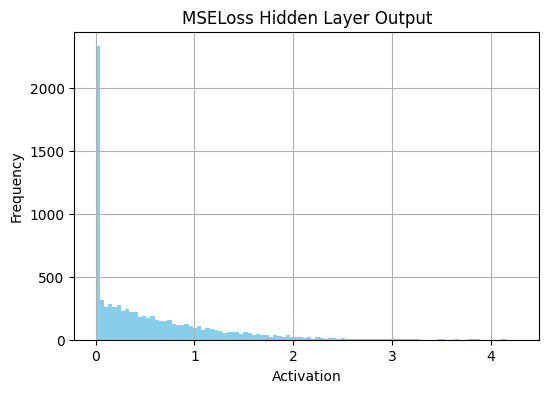

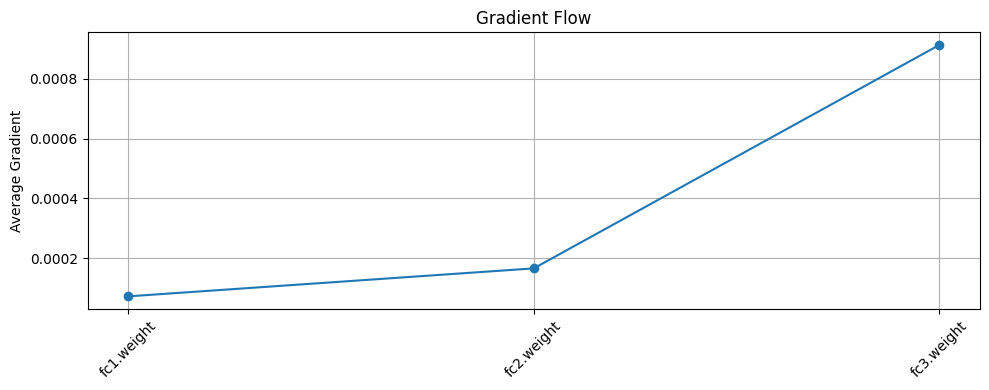

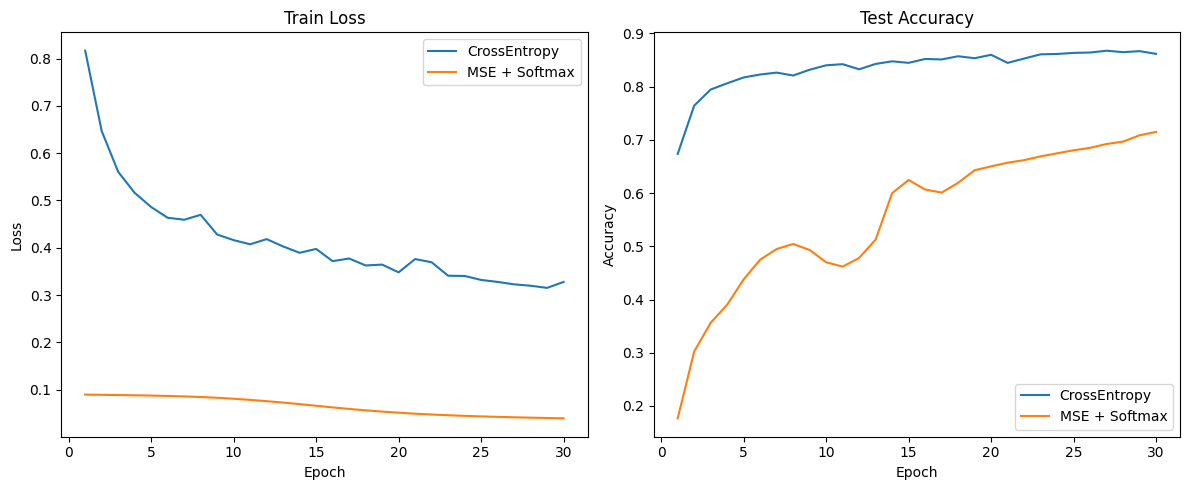


=== 실험 A 정량 비교표 ===
Loss Function  최종 정확도 (%)  Loss 최솟값  수렴까지 걸린 epoch 수
 CrossEntropy       86.14    0.3152               29
MSE + Softmax       71.48    0.0396               30


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. 하이퍼파라미터 설정
input_size = 28 * 28
num_classes = 10
batch_size = 64
epochs = 30
lr = 0.01

# 2. 데이터셋 로드 (Fashion-MNIST)
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1))  # Flatten
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.hidden_outputs = None

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        self.hidden_outputs = x.detach().cpu().numpy()  # 중간 출력 저장
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

# 4. Gradient 및 중간 분포 시각화용 함수
def plot_activation_distribution(activation_data, title="Hidden Layer Output Distribution"):
    plt.figure(figsize=(6, 4))
    plt.hist(activation_data.flatten(), bins=100, color='skyblue')
    plt.title(title)
    plt.xlabel("Activation")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_gradient_flow(model, title="Gradient Flow"):
    ave_grads = []
    layers = []
    for name, param in model.named_parameters():
        if param.requires_grad and "bias" not in name:
            layers.append(name)
            ave_grads.append(param.grad.abs().mean().item() if param.grad is not None else 0)
    plt.figure(figsize=(10, 4))
    plt.plot(layers, ave_grads, marker='o')
    plt.title(title)
    plt.ylabel("Average Gradient")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5. 평가 함수
def evaluate(model, dataloader, loss_fn, use_softmax=False):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for x, y in dataloader:
            outputs = model(x)
            if use_softmax:
                outputs = F.softmax(outputs, dim=1)
                y_onehot = F.one_hot(y, num_classes=num_classes).float()
                loss = loss_fn(outputs, y_onehot)
            else:
                loss = loss_fn(outputs, y)
            total_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)
    return total_loss / total, correct / total

# 6. 학습 함수
def train(model, optimizer, loss_fn, use_softmax=False):
    train_losses, test_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            outputs = model(x)
            if use_softmax:
                outputs = F.softmax(outputs, dim=1)
                y_onehot = F.one_hot(y, num_classes=num_classes).float()
                loss = loss_fn(outputs, y_onehot)
            else:
                loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()
        # 중간 출력 분포 시각화 (1회만)
        if epoch == epochs - 1:
            plot_activation_distribution(model.hidden_outputs, title=f"{loss_fn.__class__.__name__} Hidden Layer Output")
        # Gradient 흐름 시각화 (1회만)
        if epoch == epochs - 1:
            plot_gradient_flow(model)
        # 평가
        train_loss, train_acc = evaluate(model, train_loader, loss_fn, use_softmax)
        test_loss, test_acc = evaluate(model, test_loader, loss_fn, use_softmax)
        train_losses.append(train_loss)
        test_accuracies.append(test_acc)
    return train_losses, test_accuracies

# 7. 실험 A.1 CrossEntropy Loss 실험
model_ce = MLP(input_size, num_classes)
optimizer_ce = optim.SGD(model_ce.parameters(), lr=lr)
loss_fn_ce = nn.CrossEntropyLoss()
train_losses_ce, test_accuracies_ce = train(model_ce, optimizer_ce, loss_fn_ce, use_softmax=False)

# 8. 실험 A.2 MSE Loss with softmax 실험
model_mse = MLP(input_size, num_classes)
optimizer_mse = optim.SGD(model_mse.parameters(), lr=lr)
loss_fn_mse = nn.MSELoss()
train_losses_mse, test_accuracies_mse = train(model_mse, optimizer_mse, loss_fn_mse, use_softmax=True)

# 9. 결과 시각화
epochs_range = range(1, epochs+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses_ce, label='CrossEntropy')
plt.plot(epochs_range, train_losses_mse, label='MSE + Softmax')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_accuracies_ce, label='CrossEntropy')
plt.plot(epochs_range, test_accuracies_mse, label='MSE + Softmax')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# 10. 정량 비교표 출력
comparison_df = pd.DataFrame({
    "Loss Function": ["CrossEntropy", "MSE + Softmax"],
    "최종 정확도 (%)": [round(test_accuracies_ce[-1]*100, 2), round(test_accuracies_mse[-1]*100, 2)],
    "Loss 최솟값": [round(min(train_losses_ce), 4), round(min(train_losses_mse), 4)],
    "수렴까지 걸린 epoch 수": [np.argmin(train_losses_ce)+1, np.argmin(train_losses_mse)+1]
})

print("\n=== 실험 A 정량 비교표 ===")
print(comparison_df.to_string(index=False))

"""
=== 실험 A 정량 비교표 ===
Loss Function  최종 정확도 (%)  Loss 최솟값  수렴까지 걸린 epoch 수
 CrossEntropy       86.14    0.3152               29
MSE + Softmax       71.48    0.0396               30
"""